# Autoencoders

### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
tf.compat.v1.disable_eager_execution()

### Funções utilitárias

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')



def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap='Greys', interpolation='nearest')
    plt.axis('off')
    

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

def show_reconstructed_digits(X, X_test, outputs, model_path = None, n_test_digits = 2):
    with tf.compat.v1.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = X_test[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        plt.plot()

### PCA com um Autoencoder linear

In [4]:
import numpy.random as rnd
from sklearn.preprocessing import StandardScaler

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)


scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [5]:
tf.compat.v1.reset_default_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs
learning_rate = 0.01

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.compat.v1.layers.dense(X, n_hidden)
outputs = tf.compat.v1.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


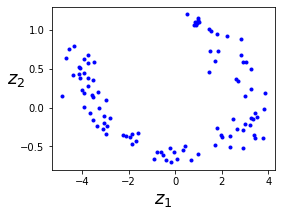

In [6]:
n_iterations = 1000
codings = hidden

with tf.compat.v1.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})
    
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.show()

### Autoencoder empilhado

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [8]:
from functools import partial
from tensorflow.keras.regularizers import l2

tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
l2_reg = 0.0001

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
he_init = tf.compat.v1.variance_scaling_initializer()
l2_regularizer = l2(l2_reg)

my_dense_layer = partial(tf.compat.v1.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [9]:
import sys

n_epochs = 5
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), 'Train MSE:', loss_train)
        saver.save(sess, 'models/my_model_all_layers.ckpt')

0 Train MSE: 0.020910986
1 Train MSE: 0.015722847
2 Train MSE: 0.015605824
3 Train MSE: 0.015891755
4 Train MSE: 0.01707118


INFO:tensorflow:Restoring parameters from models/my_model_all_layers.ckpt


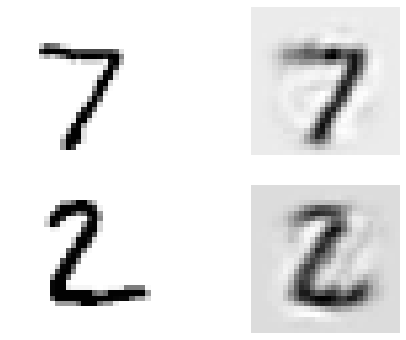

In [10]:
show_reconstructed_digits(X, X_test, outputs, 'models/my_model_all_layers.ckpt')

### Amarrando os pesos

In [11]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
l2_reg = 0.0005

regularizer = l2(l2_reg)
initializer = tf.compat.v1.variance_scaling_initializer()
activation = tf.nn.elu

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.transpose(weights2, name='weights3')  # amarrando os pesos
weights4 = tf.transpose(weights1, name='weights4')  # amarrando os pesos

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [12]:
n_epochs = 5
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), 'Train MSE:', loss_train)
        saver.save(sess, 'models/my_model_tying_weights.ckpt')

0 Train MSE: 0.027487524
1 Train MSE: 0.028513562
2 Train MSE: 0.027602447
3 Train MSE: 0.026915673
4 Train MSE: 0.026888415


INFO:tensorflow:Restoring parameters from models/my_model_tying_weights.ckpt


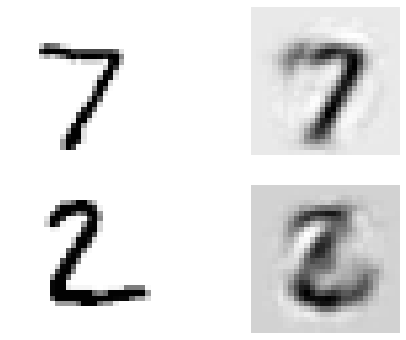

In [13]:
show_reconstructed_digits(X, X_test, outputs, 'models/my_model_tying_weights.ckpt')

### Visualizando reconstruções

INFO:tensorflow:Restoring parameters from models/my_model_tying_weights.ckpt


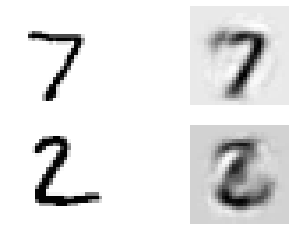

In [14]:
n_test_digits = 2
X_test = X_test[:n_test_digits]

with tf.compat.v1.Session() as sess:
    saver.restore(sess, 'models/my_model_tying_weights.ckpt')
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

### Visualizando características

INFO:tensorflow:Restoring parameters from models/my_model_tying_weights.ckpt


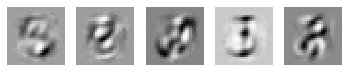

In [15]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, 'models/my_model_tying_weights.ckpt')
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])
plt.show()

### Pré-treinamento não supervisionado

In [16]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10
learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = l2(l2_reg)
initializer = tf.compat.v1.variance_scaling_initializer()

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.compat.v1.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name='weights3')

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_outputs), name='biases3')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.compat.v1.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.compat.v1.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.compat.v1.global_variables_initializer()
pretrain_saver = tf.compat.v1.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.compat.v1.train.Saver()

#### Treinamento regular

In [17]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        indices = rnd.permutation(n_labeled_instances)[:batch_size]
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print('\r{}'.format(epoch), 'Train accuracy:', accuracy_val)   
        saver.save(sess, 'models/my_model_supervised.ckpt')

0 Train accuracy: 0.96
1 Train accuracy: 0.9866667
2 Train accuracy: 0.97333336
3 Train accuracy: 0.9533333


#### Treinamento reutilizando as duas primeiras camadas pré-treinadas

In [18]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

training_op = optimizer.minimize(loss, var_list=[weights3, biases3])

with tf.compat.v1.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, 'models/my_model_supervised.ckpt')
    for epoch in range(n_epochs):
        indices = rnd.permutation(n_labeled_instances)[:batch_size]
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print('\r{}'.format(epoch), 'Train accuracy:', accuracy_val)   
        saver.save(sess, 'models/my_model_supervised_pretrained.ckpt')

INFO:tensorflow:Restoring parameters from models/my_model_supervised.ckpt
0 Train accuracy: 0.98
1 Train accuracy: 0.98
2 Train accuracy: 0.96
3 Train accuracy: 0.97333336


### Autoencoders de remoção de ruído

#### Ruído gaussiano

In [19]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
noise_level = 1.0

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.compat.v1.random_normal(tf.shape(X)) #adiciona ruído à entrada

hidden1 = tf.compat.v1.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu, name='hidden1')
hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
hidden3 = tf.compat.v1.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
outputs = tf.compat.v1.layers.dense(hidden3, n_outputs, name='outputs')

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [20]:
n_epochs = 10
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print('\r{}'.format(epoch), 'Train MSE:', loss_train)
        saver.save(sess, 'models/my_model_stacked_denoising_gaussian.ckpt')

0 Train MSE: 0.040125564
1 Train MSE: 0.040533166
2 Train MSE: 0.040195465
3 Train MSE: 0.039673954
4 Train MSE: 0.03848823
5 Train MSE: 0.041479923
6 Train MSE: 0.03995979
7 Train MSE: 0.03956004
8 Train MSE: 0.040841524
9 Train MSE: 0.041032042


#### Com dropout

In [21]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
dropout_rate = 0.3

training = tf.compat.v1.placeholder_with_default(False, shape=(), name='training')

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.compat.v1.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.compat.v1.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,  name='hidden1')
hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
hidden3 = tf.compat.v1.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
outputs = tf.compat.v1.layers.dense(hidden3, n_outputs, name='outputs')

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.


In [22]:
n_epochs = 10
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print('\r{}'.format(epoch), 'Train MSE:', loss_train)
        saver.save(sess, 'models/my_model_stacked_denoising_dropout.ckpt')

0 Train MSE: 0.027045395
1 Train MSE: 0.026575105
2 Train MSE: 0.024887197
3 Train MSE: 0.023318654
4 Train MSE: 0.024527581
5 Train MSE: 0.024261083
6 Train MSE: 0.023881724
7 Train MSE: 0.02390978
8 Train MSE: 0.023898132
9 Train MSE: 0.021940293


INFO:tensorflow:Restoring parameters from models/my_model_stacked_denoising_dropout.ckpt


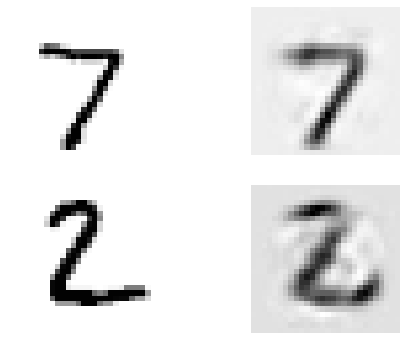

In [23]:
show_reconstructed_digits(X, X_test, outputs, 'models/my_model_stacked_denoising_dropout.ckpt')

### Autoencoder esparso

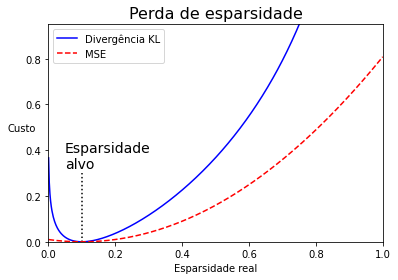

In [24]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)

kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2

plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, 'Esparsidade\nalvo', fontsize=14)
plt.plot(q, kl_div, 'b-', label='Divergência KL')
plt.plot(q, mse, 'r--', label='MSE')

plt.Figure(figsize=[12, 6])
plt.title('Perda de esparsidade', fontsize=16)
plt.legend(loc='upper left')
plt.xlabel('Esparsidade real')
plt.ylabel('Custo', rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

In [25]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 1000
n_outputs = n_inputs


def kl_divergence(p, q):
    return p * tf.math.log(p / q) + (1 - p) * tf.math.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.compat.v1.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.compat.v1.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # lote médio
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [26]:
n_epochs = 100
batch_size = 1000

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], 
                                                                        feed_dict={X: X_batch})
        if epoch % 10 == 0:
            print('Epoch: {}'.format(epoch))
            print('Train MSE:', reconstruction_loss_val, '\tSparsity loss:', sparsity_loss_val, '\tTotal loss:', loss_val)
        saver.save(sess, 'models/my_model_sparse.ckpt')

Epoch: 0
Train MSE: 0.13878581 	Sparsity loss: 0.5579046 	Total loss: 0.25036675
Epoch: 10
Train MSE: 0.027638234 	Sparsity loss: 0.06696398 	Total loss: 0.04103103
Epoch: 20
Train MSE: 0.016263714 	Sparsity loss: 0.07300292 	Total loss: 0.030864298
Epoch: 30
Train MSE: 0.013510336 	Sparsity loss: 0.055990875 	Total loss: 0.024708511
Epoch: 40
Train MSE: 0.014091983 	Sparsity loss: 0.15624483 	Total loss: 0.045340948
Epoch: 50
Train MSE: 0.011731104 	Sparsity loss: 0.22869381 	Total loss: 0.057469867
Epoch: 60
Train MSE: 0.01307029 	Sparsity loss: 0.18859872 	Total loss: 0.050790034
Epoch: 70
Train MSE: 0.021346018 	Sparsity loss: 0.4644586 	Total loss: 0.11423774
Epoch: 80
Train MSE: 0.016133286 	Sparsity loss: 0.33816016 	Total loss: 0.08376532
Epoch: 90
Train MSE: 0.012817886 	Sparsity loss: 0.7490146 	Total loss: 0.16262081


INFO:tensorflow:Restoring parameters from models/my_model_sparse.ckpt


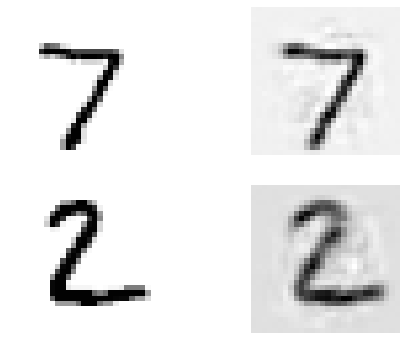

In [27]:
show_reconstructed_digits(X, X_test, outputs, 'models/my_model_sparse.ckpt')